# Autoencoder for time series

## Notebook settings

In [1]:
%config IPCompleter.greedy=True
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import numpy as np

# %load -s loadData ../scripts/dataUtilities.py 
def loadData(direc, dataset, perm = True, ratio_train = 0.8):
    datadir = direc + '/' + dataset + '/' + dataset
    data_train = np.genfromtxt(datadir + '_TRAIN.tsv', delimiter='\t')
    data_test_val = np.genfromtxt(datadir + '_TEST.tsv', delimiter='\t')[:-1]
    data = np.concatenate((data_train, data_test_val), axis=0)

    N, D = data.shape
    ind_cut = int(ratio_train * N)
    if perm:
        ind = np.random.permutation(N)
    else:
        ind = range(0, N)
    return data[ind[:ind_cut], 1:], data[ind[ind_cut:], 1:], data[ind[:ind_cut], 0], data[ind[ind_cut:], 0]

In [3]:
dataTrain, dataTest, labelsTrain, labelsTest = loadData('../data/UCRArchive_2018', 'ECG5000')

## Configuration hyperparameter

In [4]:
config = dict()  # Put all configuration information into the dict
config['num_layers'] = 2  # number of layers of stacked RNN's
config['hidden_size'] = 90  # memory cells in a layer
config['max_grad_norm'] = 5  # maximum gradient norm during training
config['batch_size'] = batch_size = 64 # number of samples for iteration
config['learning_rate'] = .005 # for exponential decay
config['crd'] = 1  # Hyperparameter for future generalization
config['num_l'] = 32 # number of units in the latent space

plot_every = 100  # after _plot_every_ GD steps, there's console output
max_iterations = 1000  # maximum number of iterations
dropout = 0.8 # Dropout rate

## Valuate sequence length

In [5]:
dataTrain.shape[0]
N = dataTrain.shape[0]
Nval = dataTest.shape[0]
D = dataTrain.shape[1]
config['sl'] = sl = D  # sequence length
print('We have %s observations with %s dimensions' % (N, D))

3999

We have 3999 observations with 140 dimensions


## Valuate class number and min class

In [6]:
num_classes = len(np.unique(labelsTrain))
base = np.min(labelsTrain)  # Check if data is 0-based
if base != 0:
    labelsTrain -= base
    labelsTest -= base

print('We have %s classes, %s is the min class value' % (num_classes, base))

We have 5 classes, 1.0 is the min class value


In [7]:
import matplotlib.pyplot as plt
from collections import Counter

# %load -s plot_data ../scripts/plotUtilities.py 
def plot_data(data, classes, plot_row=10, save = False, name = 'tmp', adjust=True):
    counts = dict(Counter(classes))
    uniqueClasses = np.unique(classes)
    num_classes = len(uniqueClasses)
    f, axarr = plt.subplots(plot_row, num_classes)
    for selectedClass in uniqueClasses:  # Loops over classes, plot as columns
        selectedClass = int(selectedClass)
        ind = np.where(classes == selectedClass)
        ind_plot = np.random.choice(ind[0], size=plot_row)
        for n in range(plot_row):  # Loops over rows
            # Only shops axes for bottom row and left column
            if n == 0:
                axarr[n, selectedClass].set_title('Class %.0f (%.0f elements)' % (selectedClass + 1, counts[float(selectedClass)]))
            if n < counts[float(selectedClass)]:
                axarr[n, selectedClass].plot(data[ind_plot[n], :])

                if not n == plot_row - 1:
                    plt.setp([axarr[n, selectedClass].get_xticklabels()], visible=False)
                if not selectedClass == 0:
                    plt.setp([axarr[n, selectedClass].get_yticklabels()], visible=False)
    
    if adjust == True:
        f.subplots_adjust(hspace=0)  # No horizontal space between subplots
        f.subplots_adjust(wspace=0)  # No vertical space between subplots
    plt.show()

    if save:
        plt.savefig(name, format='png', dpi=1000)
        
    return


## Data class plot

Populating the interactive namespace from numpy and matplotlib


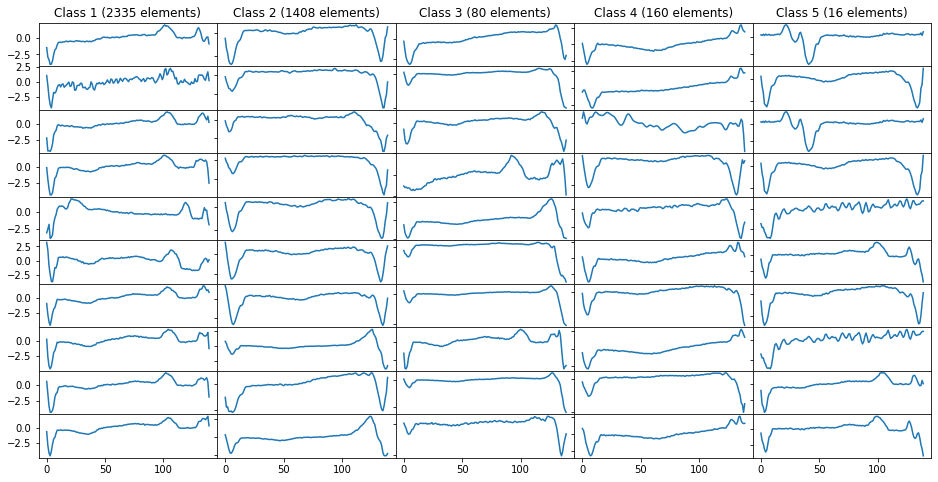

In [8]:
%pylab inline
pylab.rcParams['figure.figsize'] = (16, 8)

plot_data(dataTrain, labelsTrain)
# plot_data(dataTrain, labelsTrain, 5, True, "Prova.eps")

# Training time

## Net definition

In [9]:
import tensorflow as tf
from tensorflow.nn.rnn_cell import LSTMCell
import tensorflow_probability as tfp

class Model:
    def __init__(self, config):
        # Hyperparameters of the net
        num_layers = config['num_layers']
        hidden_size = config['hidden_size']
        max_grad_norm = config['max_grad_norm']
        batch_size = config['batch_size']
        sl = config['sl']
        crd = config['crd']
        num_l = config['num_l']
        learning_rate = config['learning_rate']
        self.sl = sl
        self.batch_size = batch_size

        # Nodes for the input variables
        self.x = tf.placeholder("float", shape=[batch_size, sl], name='Input_data')
        self.x_exp = tf.expand_dims(self.x, 1)
        self.keep_prob = tf.placeholder("float")

        with tf.variable_scope("Encoder"):
            # Th encoder cell, multi-layered with dropout
            cell_enc = tf.contrib.rnn.MultiRNNCell([LSTMCell(hidden_size) for _ in range(num_layers)])
            cell_enc = tf.contrib.rnn.DropoutWrapper(cell_enc, output_keep_prob=self.keep_prob)

            # Initial state
            initial_state_enc = cell_enc.zero_state(batch_size, tf.float32)

            # with tf.name_scope("Enc_2_lat") as scope:
            # layer for mean of z
            W_mu = tf.get_variable('W_mu', [hidden_size, num_l])

            outputs_enc, _ = tf.contrib.rnn.static_rnn(cell_enc,
                                                       inputs=tf.unstack(self.x_exp, axis=2),
                                                       initial_state=initial_state_enc)
            cell_output = outputs_enc[-1]
            b_mu = tf.get_variable('b_mu', [num_l])

            # self.z_mu is the Tensor containing the hidden representations
            # It can be used to do visualization, clustering or subsequent classification
            self.z_mu = tf.nn.xw_plus_b(cell_output, W_mu, b_mu, name='z_mu')  # mu, mean, of latent space

            # Train the point in latent space to have zero-mean and unit-variance on batch basis
            lat_mean, lat_var = tf.nn.moments(self.z_mu, axes=[1])
            self.loss_lat_batch = tf.reduce_mean(tf.square(lat_mean) + lat_var - tf.log(lat_var) - 1)

        with tf.name_scope("Lat_2_dec"):
            # layer to generate initial state
            W_state = tf.get_variable('W_state', [num_l, hidden_size])
            b_state = tf.get_variable('b_state', [hidden_size])
            z_state = tf.nn.xw_plus_b(self.z_mu, W_state, b_state, name='z_state')  # mu, mean, of latent space

        with tf.variable_scope("Decoder"):
            # The decoder, also multi-layered
            cell_dec = tf.contrib.rnn.MultiRNNCell([LSTMCell(hidden_size) for _ in range(num_layers)])

            # Initial state
            initial_state_dec = tuple([(z_state, z_state)] * num_layers)
            dec_inputs = [tf.zeros([batch_size, 1])] * sl
            # outputs_dec, _ = tf.nn.seq2seq.rnn_decoder(dec_inputs, initial_state_dec, cell_dec)
            outputs_dec, _ = tf.contrib.rnn.static_rnn(cell_dec,
                                                       inputs=dec_inputs,
                                                       initial_state=initial_state_dec)
        with tf.name_scope("Out_layer"):
            params_o = 2 * crd  # Number of coordinates + variances
            W_o = tf.get_variable('W_o', [hidden_size, params_o])
            b_o = tf.get_variable('b_o', [params_o])
            outputs = tf.concat(outputs_dec, axis=0)  # tensor in [sl*batch_size,hidden_size]
            h_out = tf.nn.xw_plus_b(outputs, W_o, b_o)
            h_mu, h_sigma_log = tf.unstack(tf.reshape(h_out, [sl, batch_size, params_o]), axis=2)
            h_sigma = tf.exp(h_sigma_log)
            dist = tfp.distributions.Normal(h_mu, h_sigma)
            px = dist.log_prob(tf.transpose(self.x))
            loss_seq = -px
            self.loss_seq = tf.reduce_mean(loss_seq)

        with tf.name_scope("train"):
            # Use learning rte decay
            global_step = tf.Variable(0, trainable=False)
            lr = tf.train.exponential_decay(learning_rate, global_step, 1000, 0.1, staircase=False)

            self.loss = self.loss_seq + self.loss_lat_batch

            # Route the gradients so that we can plot them on Tensorboard
            tvars = tf.trainable_variables()
            # We clip the gradients to prevent explosion
            grads = tf.gradients(self.loss, tvars)
            grads, _ = tf.clip_by_global_norm(grads, max_grad_norm)
            self.numel = tf.constant([[0]])

            # And apply the gradients
            optimizer = tf.train.AdamOptimizer(lr)
            gradients = zip(grads, tvars)
            self.train_step = optimizer.apply_gradients(gradients, global_step=global_step)
            #      for gradient, variable in gradients:  #plot the gradient of each trainable variable
            #        if isinstance(gradient, ops.IndexedSlices):
            #          grad_values = gradient.values
            #        else:
            #          grad_values = gradient
            #
            #        self.numel +=tf.reduce_sum(tf.size(variable))
            #        tf.summary.histogram(variable.name, variable)
            #        tf.summary.histogram(variable.name + "/gradients", grad_values)
            #        tf.summary.histogram(variable.name + "/gradient_norm", clip_ops.global_norm([grad_values]))

            self.numel = tf.constant([[0]])
        tf.summary.tensor_summary('lat_state', self.z_mu)
        # Define one op to call all summaries
        self.merged = tf.summary.merge_all()
        # and one op to initialize the variables
        self.init_op = tf.global_variables_initializer()

## Training model

In [20]:
import os

model = Model(config)
sess = tf.Session()
perf_collect = np.zeros((2, int(np.floor(max_iterations / plot_every))))

batch_size = config['batch_size']

# Start of the train
epochs = np.floor(batch_size * max_iterations / N)

print('Train with approximately %d epochs' % epochs)

sess.run(model.init_op)

step = 0  # Step is a counter for filling the numpy array perf_collect
for i in range(max_iterations):
    batch_ind = np.random.choice(N, batch_size, replace=False)
    result = sess.run([model.loss, model.loss_seq, model.loss_lat_batch, model.train_step],
                      feed_dict={model.x: dataTrain[batch_ind], model.keep_prob: dropout})
    
    if i % plot_every == 0:
        # Save train performances
        perf_collect[0, step] = loss_train = result[0]
        loss_train_seq, lost_train_lat = result[1], result[2]

        # Calculate and save validation performance
        batch_ind_val = np.random.choice(Nval, batch_size, replace=False)

        result = sess.run([model.loss, model.loss_seq, model.loss_lat_batch, model.merged],
                          feed_dict={model.x: dataTest[batch_ind_val], model.keep_prob: 1.0})
        perf_collect[1, step] = loss_val = result[0]
        loss_val_seq, lost_val_lat = result[1], result[2]
        # and save to Tensorboard
        summary_str = result[3]

        print("At %6s / %6s train (%5.3f, %5.3f, %5.3f), val (%5.3f, %5.3f,%5.3f) in order (total, seq, lat)" % (
        i, max_iterations, loss_train, loss_train_seq, lost_train_lat, loss_val, loss_val_seq, lost_val_lat))
        step += 1
    
saver = tf.train.Saver()
saver.save(sess, os.path.join("logs/ecg5000.ckpt"), step)

print("model trained, saved in logs directory")

ValueError: Variable Encoder/W_mu already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "<ipython-input-9-47a9c22f86e4>", line 34, in __init__
    W_mu = tf.get_variable('W_mu', [hidden_size, num_l])
  File "<ipython-input-10-7c7e142eb940>", line 3, in <module>
    model = Model(config)
  File "/home/flavio/Universita/Progetto-Data-science/env/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3325, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/home/flavio/Universita/Progetto-Data-science/env/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3248, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/flavio/Universita/Progetto-Data-science/env/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3057, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)


## Get latent vector from model run on dataTest

In [12]:
saver = tf.train.Saver()
saver.restore(sess, save_path=os.path.join("logs/ecg5000.ckpt-10"))
start = 0
label = []  # The label to save to visualize the latent space
z_run = []

while start + batch_size < Nval:
    run_ind = range(start, start + batch_size)
    z_mu_fetch = sess.run(model.z_mu, feed_dict={model.x: dataTest[run_ind], model.keep_prob: 1.0})
    z_run.extend(z_mu_fetch.tolist())
    start += batch_size

W0714 14:07:18.972531 139698669495936 deprecation.py:323] From /home/flavio/Universita/Progetto-Data-science/env/lib/python3.7/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


## Clustering based on latent vector of net

In [25]:
from sklearn.cluster import KMeans
from itertools import groupby

def getClustering(features, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    res = kmeans.fit_predict(features)
    kmeans.labels_ +=1
    res = res -1
    groups = groupby(sorted(zip(tuple(res), tuple(labelsTest))), lambda x: x[0])
    counts = {k: dict(Counter(x[1] for x in g)) for k, g in groups}
    return res, counts

In [26]:
getClustering(z_run,5)

(array([2, 1, 1, 4, 1, 3, 1, 0, 1, 1, 0, 4, 1, 4, 4, 4, 1, 3, 3, 0, 1, 1,
        0, 4, 2, 4, 1, 0, 4, 4, 3, 2, 3, 0, 1, 2, 3, 0, 2, 1, 3, 3, 4, 3,
        0, 1, 2, 1, 1, 0, 3, 4, 4, 1, 1, 3, 0, 0, 2, 4, 3, 1, 4, 1, 1, 4,
        1, 4, 3, 4, 1, 3, 0, 3, 0, 0, 1, 2, 2, 3, 3, 4, 0, 1, 4, 0, 4, 1,
        1, 0, 1, 3, 3, 0, 4, 1, 1, 0, 3, 4, 4, 4, 0, 2, 4, 4, 1, 3, 3, 3,
        1, 4, 1, 1, 0, 2, 1, 1, 4, 0, 4, 0, 1, 2, 4, 1, 4, 4, 4, 1, 3, 0,
        4, 1, 3, 3, 1, 0, 1, 4, 4, 4, 1, 1, 4, 3, 2, 2, 0, 2, 4, 3, 1, 4,
        3, 3, 2, 1, 4, 1, 1, 4, 4, 4, 1, 4, 3, 0, 0, 1, 1, 2, 4, 1, 2, 1,
        4, 0, 0, 1, 2, 1, 0, 1, 4, 1, 3, 4, 1, 1, 3, 0, 4, 2, 1, 2, 4, 0,
        1, 3, 0, 4, 4, 3, 1, 3, 4, 4, 3, 1, 1, 0, 4, 1, 3, 3, 4, 4, 1, 3,
        1, 1, 1, 3, 0, 1, 1, 3, 4, 4, 1, 4, 2, 1, 3, 1, 1, 1, 1, 3, 1, 1,
        4, 3, 2, 4, 0, 1, 1, 1, 0, 4, 4, 1, 4, 0, 2, 1, 4, 3, 4, 1, 3, 1,
        4, 1, 3, 1, 3, 2, 3, 1, 1, 3, 1, 4, 1, 0, 1, 4, 3, 4, 0, 2, 1, 3,
        1, 1, 0, 0, 4, 1, 0, 4, 1, 4, 

### Plot function for clustering result

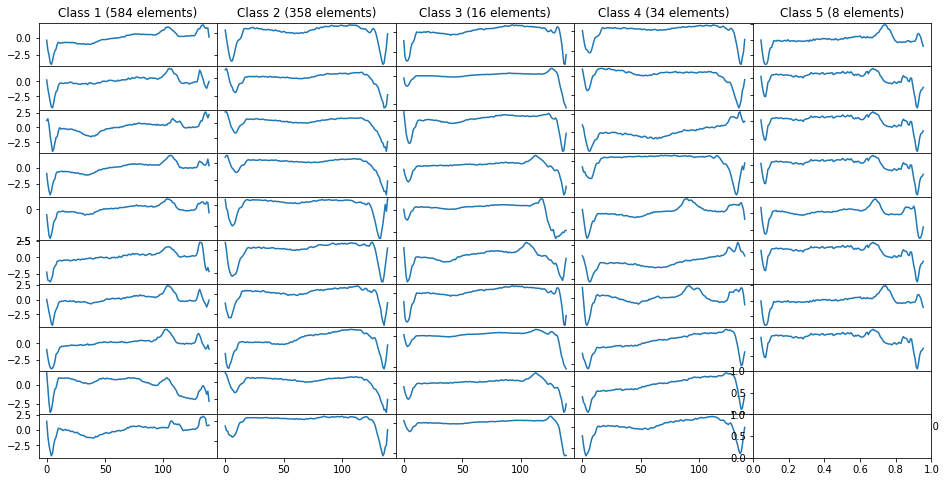

In [14]:
pylab.rcParams['figure.figsize'] = (16, 8)
plot_data(dataTest, labelsTest)

In [15]:
print(np.min(labelsTest),np.min(res))

0.0 0


## Plot of our results

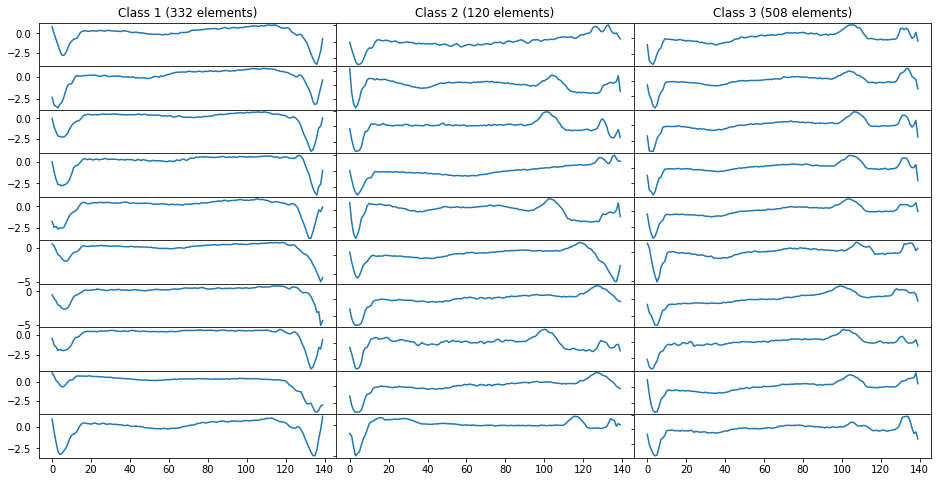

In [16]:
pylab.rcParams['figure.figsize'] = (16, 8)
plot_data(dataTest, res)

## Visualize latent vector on PCA and tSNE

In [18]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

def plot_z_run(z_run, label, ):
    f1, ax1 = plt.subplots(2, 1)

    # First fit a PCA
    PCA_model = TruncatedSVD(n_components=3).fit(z_run)
    z_run_reduced = PCA_model.transform(z_run)
    ax1[0].scatter(z_run_reduced[:, 0], z_run_reduced[:, 1], c=label, marker='*', linewidths=0)
    ax1[0].set_title('PCA on z_run')

    # THen fit a tSNE
    tSNE_model = TSNE(verbose=2, perplexity=80, min_grad_norm=1E-12, n_iter=3000)
    z_run_tsne = tSNE_model.fit_transform(z_run)
    ax1[1].scatter(z_run_tsne[:, 0], z_run_tsne[:, 1], c=label, marker='*', linewidths=0)
    ax1[1].set_title('tSNE on z_run')

    plt.show()
    return

[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 960 samples in 0.001s...
[t-SNE] Computed neighbors for 960 samples in 0.063s...
[t-SNE] Computed conditional probabilities for sample 960 / 960
[t-SNE] Mean sigma: 0.556363
[t-SNE] Computed conditional probabilities in 0.051s
[t-SNE] Iteration 50: error = 51.0122299, gradient norm = 0.2158540 (50 iterations in 0.302s)
[t-SNE] Iteration 100: error = 48.6212196, gradient norm = 0.1632985 (50 iterations in 0.246s)
[t-SNE] Iteration 150: error = 48.2876778, gradient norm = 0.1478961 (50 iterations in 0.229s)
[t-SNE] Iteration 200: error = 48.2343597, gradient norm = 0.1615439 (50 iterations in 0.226s)
[t-SNE] Iteration 250: error = 48.2095757, gradient norm = 0.1581092 (50 iterations in 0.226s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.209576
[t-SNE] Iteration 300: error = 0.2968814, gradient norm = 0.0006432 (50 iterations in 0.208s)
[t-SNE] Iteration 350: error = 0.2615896, gradient norm = 0.0002155 

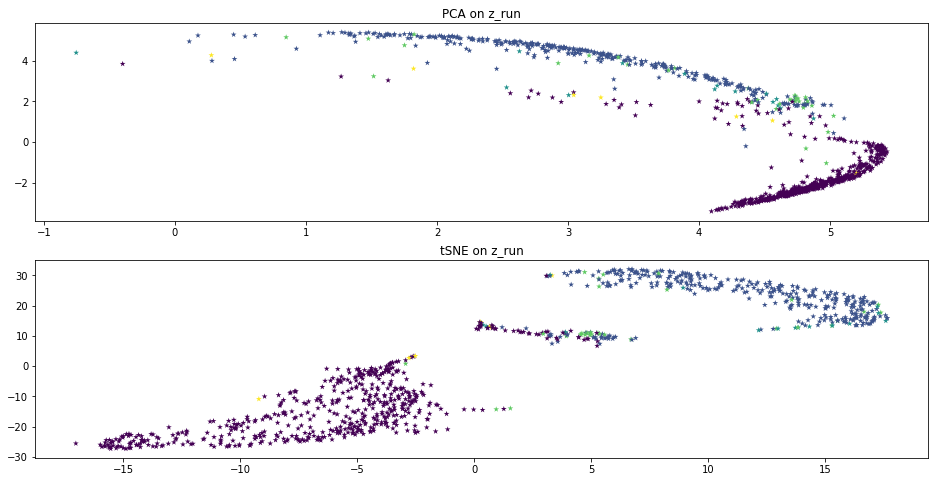

In [19]:
# Extract the latent space coordinates of the validation set
start = 0
label = []  # The label to save to visualize the latent space
z_run = []

while start + batch_size < Nval:
    run_ind = range(start, start + batch_size)
    z_mu_fetch = sess.run(model.z_mu, feed_dict={model.x: dataTest[run_ind], model.keep_prob: 1.0})
    z_run.append(z_mu_fetch)
    start += batch_size

z_run = np.concatenate(z_run, axis=0)
label = labelsTest[:start]

plot_z_run(z_run, label)